_Andre Binette_ <abinette@bankofcanada.ca>

_Dmitri Tchebotarev_ <dtchebotarev@bankofcanada.ca>

# MPR Forecast for real GDP growth

This workbook should "just work". If it does not, or if you find an error, please email the authors above.

# Set up the python environment

### Display plots inline

In [1]:
%matplotlib inline

### Import required modules 

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

/home/int/tche/.conda/envs/d/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Display options

In [3]:
pd.set_option('display.max_colwidth',-1)
sns.set(context='paper',rc={'figure.facecolor':'white','axes.facecolor':'gainsboro','grid.color':'white'})

## Import data

Download data from BoC website

In [4]:
web_data = pd.read_csv(\
        'http://www.bankofcanada.ca/valet/observations/group/SAN-2017-21/csv',\
                       skiprows=37,index_col=0)
web_data.index=pd.to_datetime(web_data.index).year
web_data.index.name = 'Year'

### GDP data

In [5]:
gdp_data = web_data.iloc[:,[11,13,12,9,10,14,15]]
gdp_data = gdp_data.dropna(how='all')
gdp_data.columns = ['real GDP (fisher)','real GDP (laspeyres)','nominal GDP',
                    'real R&D','nominal R&D','real weapons','nominal weapons']

### Forecast data - MPR

In [6]:
fcast = web_data.iloc[:,5:9]
fcast = fcast.dropna(how='all')
fcast.columns = ['FH1','FH2','FH3','FH4']

## Define helper functions

In [7]:
# geometric average of percentage points
# works on numbers, and various pandas and numpy types that
# understand multiplication and division
def gavg(*args):
    n = 0
    p = 1
    for arg in args:
        n += 1
        arg = arg/100 + 1
        p = p*arg
    p = p ** (1/n)
    p = p - 1
    p = p * 100
    return p

In [8]:
# make all y axes in a plot have the same min/max. based on
# the most extreme values of all the axes.
def y_axes(plt):
    axmin = min([ax.get_ylim()[0] for ax in plt.gcf().axes])
    axmax = max([ax.get_ylim()[1] for ax in plt.gcf().axes])
    for ax in plt.gcf().axes:
        ax.set_ylim(axmin,axmax)

In [9]:
# Take a number and return a string, formatted 0.00
def f1(x):
    return '{:1.2f}'.format(x)

# Data
## Creating adjusted real GDP figure

Calculate Weapons and R&D's contribution to growth

In [10]:
growth = gdp_data.loc[:,('real R&D','real weapons')].pct_change()*100
share = pd.concat([
    gdp_data.loc[:,'nominal R&D'].divide(gdp_data.loc[:,'nominal GDP']),
    gdp_data.loc[:,'nominal weapons'].divide(gdp_data.loc[:,'nominal GDP'])
                ],axis=1)
share.columns = growth.columns
CTG = share.shift(1)*growth
CTG = CTG.loc[1997:2013]

Breakdown of our adjustment to final GDP to match the GDP series at the time when forecasts were made.

In [11]:
appendix_b = gdp_data.loc[:,'real GDP (fisher)'].pct_change().loc[1997:]*100
appendix_b.name = 'Chain Fisher (current methodology)'
appendix_b = pd.concat([appendix_b,gdp_data.loc[:,'real GDP (laspeyres)'].pct_change().loc[1997:2002].subtract(appendix_b.divide(100)).rename('Laspeyres index')*100],axis=1)
appendix_b.loc[1997:2002,'Software'] = np.array([.06,.05,.08,.08,.0675,.0675])
appendix_b.loc[1997:2013,'R&D and Weapons'] = CTG.sum(axis=1)
appendix_b.loc[:,'Adjusted GDP'] = appendix_b.loc[:,'Chain Fisher (current methodology)'] +\
                                    appendix_b.loc[:,'Laspeyres index'].fillna(0) -\
                                    appendix_b.loc[:,'Software'].fillna(0) -\
                                    appendix_b.loc[:,'R&D and Weapons'].fillna(0)

Create a dataframe with the different forecast horizons. The dataframe has slight differences around 2001-2002 and 2013 so that the timing of the methodological changes matches the timing of the forecasts more closely. 

In [12]:
combined_gdp = pd.DataFrame(columns = ['FH1', 'FH2','FH3','FH4'], index=appendix_b.index, 
                             data = np.transpose(
                                 np.tile(appendix_b.loc[:,'Adjusted GDP'].values,[4,1])
                                                 )
                            )
combined_gdp.loc[2002,'FH2'] = appendix_b.loc[2002,'Chain Fisher (current methodology)'] - \
                                appendix_b.loc[2002,'R&D and Weapons']
combined_gdp.loc[2013,'FH3'] = appendix_b.loc[2013,'Chain Fisher (current methodology)']
combined_gdp.loc[2002,'FH3'] = combined_gdp.loc[2002,'FH2']
combined_gdp.loc[2001,'FH4'] = appendix_b.loc[2001,'Chain Fisher (current methodology)'] - \
                                appendix_b.loc[2001,'R&D and Weapons']
combined_gdp.loc[2002,'FH4'] = combined_gdp.loc[2002,'FH3']
combined_gdp.loc[2013,'FH4'] = combined_gdp.loc[2013,'FH3']
combined_gdp.loc[:,'APRIL'] = gavg(combined_gdp.loc[:,'FH3'].shift(1),combined_gdp.loc[:,'FH1'])
combined_gdp.loc[:,'OCTOBER'] = gavg(combined_gdp.loc[:,'FH4'].shift(1),combined_gdp.loc[:,'FH2'])

Create 2 year average of GDP growth

In [13]:
gdp_data_2y = pd.DataFrame(index=appendix_b.index[1:],columns=appendix_b.columns)
for col in gdp_data_2y.columns:
    gdp_data_2y.loc[:,col] = gavg(appendix_b.loc[:,col].shift(1),appendix_b.loc[:,col])

## Create MPR forecast dataframe
Create 2 year average of forecast of GDP growth

In [14]:
fcast_2y = pd.DataFrame(index = fcast.index[1:], columns = ['APRIL', 'OCTOBER'])
fcast_2y.loc[:,'APRIL'] = gavg(fcast.loc[:,'FH3'].values[:-1],fcast.loc[:,'FH1'].values[1:])
fcast_2y.loc[:,'OCTOBER'] = gavg(fcast.loc[:,'FH4'].values[:-1],fcast.loc[:,'FH2'].values[1:])

## Create forecast errors

In [15]:
combined_fcast = pd.concat((fcast,fcast_2y),axis=1)
forecast_errors = combined_gdp.subtract(combined_fcast).dropna(how='all')
combined_fcast.index.name='year'
combined_gdp.index.name='year'
combined_fcast.columns.name='Forecast Horizon'
combined_gdp.columns.name='Forecast Horizon'

## Create MPR RMSEs and ratio with naive and Consensus Economics RMSEs
The values for the naive forecaster and CE are hardcoded because they are calculated outside this file.

In [16]:
# RMSE for MPR forecast
rmse = pd.DataFrame()
for col in ['FH1','FH2','FH3','FH4','APRIL','OCTOBER']:
    val = np.sqrt(forecast_errors.loc[:,col].pow(2).mean())
    rmse.loc['RMSE',col]=val.item()

In [17]:
# naive forecasters
rmse_gdp = rmse.divide([2.04,2.03,1.52,0.74,1.53,1.21])

In [18]:
# consensus economics
rmse_cons = rmse.divide([1.7388,1.6019,0.8739,0.6005,1.1112,0.9490])

# Figures

## Figure 1

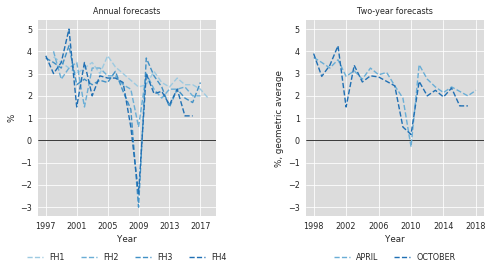

In [19]:
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.set_title("Annual forecasts",fontsize='small')
pal = sns.color_palette('Blues',n_colors=7)
for i in range(4):
    ax.plot(fcast.iloc[:,i],color=pal[i+2],linestyle='dashed')
ax.set_ylabel('%')
ax.set_xlabel('Year')
ax.axhline(y=0,c='k',zorder=1,linewidth=.75)
ax.set_xticks([v for i, v in enumerate(fcast.index) if i % 4 == 0])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=4)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])
ax = plt.subplot(122)
ax.set_title("Two-year forecasts",fontsize='small')
pal = sns.color_palette('Blues',n_colors=3)
for i in range(4,6):
    ax.plot(combined_fcast.iloc[:,i],color=pal[i-3],linestyle='dashed')
ax.set_ylabel('%, geometric average')
ax.set_xlabel('Year')
ax.axhline(y=0,c='k',zorder=1,linewidth=.75)
ax.set_xticks([v for i, v in enumerate(fcast.index[1:]) if i % 4 == 0])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=3)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.2])
plt.subplots_adjust(bottom=.2, wspace=.5)
y_axes(plt)

## Figure 2

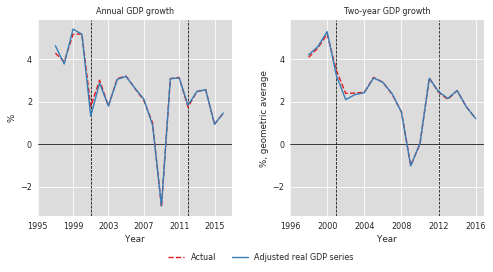

In [20]:
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
pal = sns.color_palette('Set1',n_colors=2)
c1 = pal[1]
ax.plot(appendix_b.iloc[:,0],color=pal[0],linestyle='dashed',label='Actual')
ax.plot(appendix_b.iloc[:,4],color=pal[1],label='Adjusted real GDP series')
ax.set_ylabel('%')
ax.set_xlabel('Year')
ax.axhline(y=0.0,c="k",zorder=1,linewidth=.75)
ax.axvline(x=2001,c="k",linestyle='dashed',zorder=1,linewidth=.75)
ax.axvline(x=2012,c="k",linestyle='dashed',zorder=1,linewidth=.75)
ax.set_xticks([v for i, v in enumerate(gdp_data.index.append(pd.Index([2017]))) if i % 4 == 0])
ax.legend(loc='upper center', bbox_to_anchor=(1.15, -0.15),ncol=2);
ax.set_title('Annual GDP growth',fontsize='small')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax = plt.subplot(122)
pal = sns.color_palette('Set1',n_colors=2)
ax.plot(gdp_data_2y.iloc[:,0],color=pal[0],linestyle='dashed',label='Actual')
ax.plot(gdp_data_2y.iloc[:,4],color=pal[1],label='Adjusted real GDP series')
ax.set_title('Two-year GDP growth',fontsize='small')
ax.set_ylabel('%, geometric average')
ax.set_xlabel('Year')
ax.axhline(y=0.0,c="k",zorder=1,linewidth=.75)
ax.axvline(x=2001,c="k",linestyle='dashed',zorder=1,linewidth=.75)
ax.axvline(x=2012,c="k",linestyle='dashed',zorder=1,linewidth=.75)
ax.set_xticks([v for i, v in enumerate(gdp_data.index[1:].append(pd.Index([2017,2018]))) if i % 4 == 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.subplots_adjust(wspace=.3,bottom=.2)
y_axes(plt)

## Figure 3

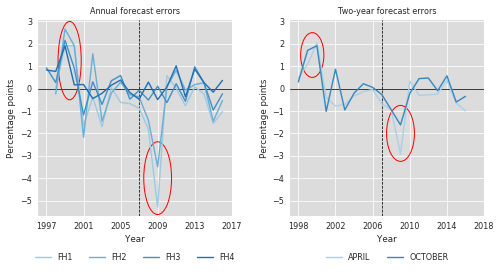

In [21]:
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.set_title("Annual forecast errors", fontsize='small')
pal = sns.color_palette('Blues',n_colors=7)
for i in range(4):
    ax.plot(forecast_errors.iloc[:,i],color=pal[i+2])
ax.add_artist(Ellipse((1999.5,1.25),width=2.5,height=3.5,
                      alpha=1,edgecolor='r',fill=False,linewidth=1))
ax.add_artist(Ellipse((2009,-4),width=3,height=3.25,
                      alpha=1,edgecolor='r',fill=False,linewidth=1))
ax.axhline(y=0,c='k',zorder=1,linewidth=.75)
ax.axvline(x=2007,c="k",linestyle='dashed',zorder=1,linewidth=.75)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=4)
ax.set_xticks([v for i, v in enumerate(forecast_errors.index.append(pd.Index([2017,2018]))) if i % 4 == 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])
ax.set_ylabel("Percentage points")
ax.set_xlabel('Year')
ax = plt.subplot(122)
ax.set_title("Two-year forecast errors",fontsize='small')
pal = sns.color_palette('Blues',n_colors=2)
for i in range(4,6):
    ax.plot(forecast_errors.iloc[:,i],color=pal[i-4])
ax.set_ylabel('Percentage points')
ax.set_xlabel('Year')
ax.axhline(y=0,c='k',zorder=1,linewidth=.75)
ax.axvline(x=2007,c="k",linestyle='dashed',zorder=1,linewidth=.75)
ax.add_artist(Ellipse((1999.5,1.5),width=2.5,height=2,
                      alpha=1,edgecolor='r',fill=False,linewidth=1))
ax.add_artist(Ellipse((2009,-2),width=3,height=2.5,
                      alpha=1,edgecolor='r',fill=False,linewidth=1))
ax.set_xticks([v for i, v in enumerate(forecast_errors.index[1:].append(pd.Index([2017,2018]))) if i % 4 == 0])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=3)
plt.subplots_adjust(bottom=.2,wspace=.3)
y_axes(plt)

## Figure 4

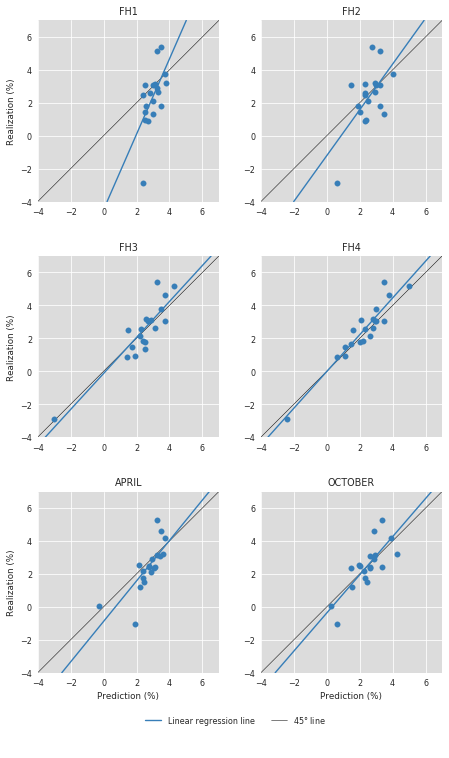

In [22]:
f = plt.figure(figsize=(8,12))
levels = combined_fcast.columns
pmin = np.floor(min(combined_fcast.min().min(),combined_gdp.min().min()))-1
pmax = np.ceil(max(combined_fcast.max().max(),combined_gdp.max().max()))+1
for i, v in enumerate(levels):
    ax = plt.subplot(321+i)
    plotdf = pd.concat((combined_fcast.loc[:,v].rename('Prediction (%)'),combined_gdp.loc[:,v].rename('Realization (%)')),axis=1).dropna(how='any')
    ax.scatter(y='Realization (%)',x='Prediction (%)',data=plotdf,zorder=3,color=c1)
    ax.set_ylabel('Realization (%)') if i%2==0 else None
    ax.set_xlabel('Prediction (%)') if i>3 else None
    ax.set_ylim(pmin,pmax)
    ax.set_xlim(pmin,pmax)
    ax.set_aspect(1)
    l2 = ax.plot([pmin,pmax],[pmin,pmax],color='k',zorder=1,linewidth=.5,label='45$\degree$ line')
    b_1, b_0 = np.polyfit(plotdf.loc[:,'Prediction (%)'],plotdf.loc[:,'Realization (%)'],deg=1)
    l = ax.plot([(pmin-b_0)/b_1,(pmax-b_0)/b_1],[pmin,pmax],color=c1,zorder=2,label='Linear regression line')
    ax.set_title(v)
plt.subplots_adjust(hspace=.3,wspace=0)
plt.figlegend([l[0],l2[0]],[l[0].get_label(),l2[0].get_label()],loc='lower left',ncol=2,bbox_to_anchor=(0.24,0.03));

## Figure 5

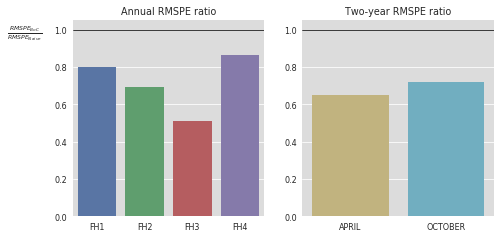

In [23]:
plt.figure(figsize=(9,4))
p = plt.subplot(121)
sns.barplot(data=rmse_gdp.iloc[:,0:4],ax=p,zorder=2)
p.set_ylabel(r"$\frac{RMSPE_{BoC}}{RMSPE_{Naive}}$",rotation='horizontal')
p.yaxis.set_label_coords(-.25, .89)
p.set_title("Annual RMSPE ratio")
plt.axhline(y=1,zorder=1,color='k',linewidth=.75)
box = p.get_position()
plt.subplots_adjust(left=.25,bottom=.2)
p = plt.subplot(122)
p.set_title("Two-year RMSPE ratio")
sns.barplot(data=rmse_gdp.iloc[:,4:6],ax=p,zorder=2,palette=sns.color_palette()[4:])
plt.axhline(y=1,zorder=1,color='k',linewidth=.75)
y_axes(plt)

## Figure 6

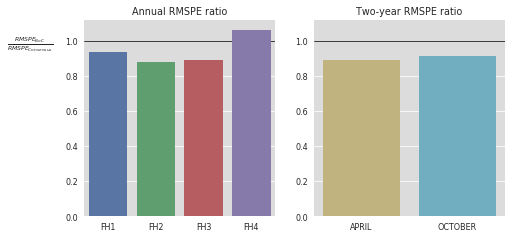

In [24]:
plt.figure(figsize=(9,4))
p = plt.subplot(121)
sns.barplot(data=rmse_cons.iloc[:,0:4],ax=p,zorder=2)
p.set_ylabel(r"$\frac{RMSPE_{BoC}}{RMSPE_{Consensus}}$",rotation='horizontal')
p.yaxis.set_label_coords(-.28 , .83)
p.set_title("Annual RMSPE ratio")
plt.axhline(y=1,zorder=1,color='k',linewidth=.75)
box = p.get_position()
plt.subplots_adjust(left=.25,bottom=.2)
p = plt.subplot(122)
p.set_title("Two-year RMSPE ratio")
sns.barplot(data=rmse_cons.iloc[:,4:6],ax=p,zorder=2,palette=sns.color_palette()[4:])
plt.axhline(y=1,zorder=1,color='k',linewidth=.75);
y_axes(plt)

# Tables

## Table 2 - Forecast error bias with and without Asian crisis and Great Recession

In [25]:
samples = ['Full Sample','','1997-2006','','2007-2016','']
stats_table = pd.DataFrame(index=samples,
                              columns = forecast_errors.columns)
numeric_table = stats_table.copy()
for j,col in enumerate(forecast_errors.columns):
    for i,s in enumerate(stats_table.index):
        if i in [0,1]:
            s_n = slice(1997,2016)
        elif i in [2,3]:
            s_n = slice(1997,2006)
        elif i in [4,5]:
            s_n = slice(2007,2016)
        y = forecast_errors.loc[s_n,col].dropna()
        if i % 2 == 1:
            y = y.loc[[x for x in y.index if x not in [1999,2000]]]
            if col not in ['FH3','FH4']:
                y = y.loc[[x for x in y.index if x !=2009]]
        x = np.ones(y.shape)
        length = len(x)
        n_lags = int(4*(length/100)**(2/9))
        p_v = sm.OLS(y,x).fit(cov_type='HAC',cov_kwds={'maxlags':n_lags,'use_correction':True}).pvalues.item()
        numeric_table.iloc[i,j] = y.mean()
        stats_table.iloc[i,j] = ('(' if i%2 == 1 else '') + f1(y.mean()) + (')' if i%2 == 1 else '')+ \
        ('*' if p_v<.1 else '') + \
        ('*' if p_v<.05 else '') + \
        ('*' if p_v<.01 else '') 
stats_table

Forecast Horizon,FH1,FH2,FH3,FH4,APRIL,OCTOBER
Full Sample,-0.63*,-0.21,0.09,0.25*,-0.27,0.01
,(-0.66)***,(-0.31)*,(-0.07),(0.16),(-0.33)***,(-0.11)
1997-2006,-0.13,0.23,0.32,0.36,0.13,0.32
,(-0.71)***,(-0.36),(0.01),(0.19),(-0.27),(-0.11)
2007-2016,-1.09**,-0.60,-0.14,0.14,-0.63**,-0.26
,(-0.62)***,(-0.28),(-0.14),(0.14),(-0.38)***,(-0.11)


## Table 3 - RMSPE with and without bias (RMSPE vs Std. Dev.)

In [26]:
rmse_table = pd.DataFrame(columns=['FH1', 'FH2', 'FH3', 'FH4', 'APRIL', 'OCTOBER']
                          ,index = ['Full sample','',
                                                '1997-2006','',
                                               '2007-2016',''])
for col in rmse_table.columns:
    for s in rmse_table.index:
        if s == 'Full sample':
            i = 0
            s_n = slice(1997,2016)
        elif s == '1997-2006':
            i = 1 
            s_n = slice(1997,2006)
        elif s == '2007-2016':
            i = 2 
            s_n = slice(2007,2016)
        rmse_table.iloc[i*2].loc[col] = f1(np.sqrt(forecast_errors.loc[s_n,col].pow(2).mean()))
        rmse_table.iloc[i*2+1].loc[col] = '({})'.format(f1(forecast_errors.loc[s_n,col].std(ddof=0)))
rmse_table

,FH1,FH2,FH3,FH4,APRIL,OCTOBER
Full sample,1.63,1.41,0.78,0.64,0.99,0.87
,(1.50),(1.39),(0.77),(0.59),(0.96),(0.87)
1997-2006,1.25,1.50,0.95,0.74,0.88,1.03
,(1.24),(1.48),(0.90),(0.64),(0.87),(0.97)
2007-2016,1.91,1.32,0.55,0.52,1.08,0.70
,(1.57),(1.18),(0.53),(0.50),(0.88),(0.65)


## Table 4 - Mincer Zarnowitz result

In [27]:
x = combined_fcast.where(~combined_gdp.isnull())
y = combined_gdp.where(~combined_fcast.isnull())
resdf = pd.DataFrame(index = ['Constant',' ','Forecast',' ','R-Squared',' ','Joint F-Test'],
                    columns = x.columns)
for i, col in enumerate(x.columns):
    model = sm.OLS(y.loc[:,col].dropna(),sm.add_constant(x.loc[:,col].dropna()))
    length = x.loc[:,col].dropna().shape[0]
    # newey west lag selection
    n_lags = int(4*(length/100)**(2/9))
    res = model.fit(cov_type='HAC',cov_kwds={'maxlags':n_lags,'use_correction':True})
    R = '({} = 1), (const = 0)'.format(col)
    resdf.iloc[0,i]=f1(res.params.get('const'))
    resdf.iloc[1,i]='({})'.format(f1(res.bse.get('const')))
    resdf.iloc[2,i]=f1(res.params.get(col))
    resdf.iloc[3,i]='({})'.format(f1(res.bse.get(col)))
    resdf.iloc[4,i]='{}'.format(f1(res.rsquared))
    resdf.iloc[5,i]=' '
    resdf.iloc[6,i]=f1(res.f_test(R).fvalue.item()) + \
    ('*' if res.f_test(R).pvalue.item()<.1 else '') + \
    ('*' if res.f_test(R).pvalue.item()<.05 else '') + \
    ('*' if res.f_test(R).pvalue.item()<.01 else '')
resdf

Forecast Horizon,FH1,FH2,FH3,FH4,APRIL,OCTOBER
Constant,-4.49,-1.21,-0.13,-0.01,-0.89,-0.37
,(2.62),(1.82),(0.23),(0.08),(0.70),(0.61)
Forecast,2.29,1.39,1.09,1.12,1.23,1.16
,(0.85),(0.66),(0.12),(0.06),(0.27),(0.24)
R-Squared,0.34,0.37,0.81,0.90,0.57,0.64
,,,,,,
Joint F-Test,2.61,0.32,0.32,1.84,1.39,0.22


## Table 5 - Hit Ratio

In [28]:
combined_fcast_diff = combined_fcast.copy()
for year in combined_fcast_diff.index:
    for col in combined_fcast_diff.columns:
        try:
            if col == 'FH1':
                combined_fcast_diff.loc[year,col] = combined_fcast.loc[year,'FH1'] - combined_fcast.loc[year-1,'FH3']
            elif col == 'FH2':
                combined_fcast_diff.loc[year,col] = combined_fcast.loc[year,'FH2'] - combined_fcast.loc[year-1,'FH4']
            elif col == 'FH3':
                combined_fcast_diff.loc[year,col] = combined_fcast.loc[year,'FH3'] - combined_gdp.loc[year-1,'FH3']
            elif col == 'FH4':
                combined_fcast_diff.loc[year,col] = combined_fcast.loc[year,'FH4'] - combined_gdp.loc[year-1,'FH4']
            elif col == 'APRIL':
                combined_fcast_diff.loc[year,col] = combined_fcast.loc[year,'APRIL'] - combined_gdp.loc[year-2,'APRIL']
            elif col == 'OCTOBER':
                combined_fcast_diff.loc[year,col] = combined_fcast.loc[year,'OCTOBER'] - combined_gdp.loc[year-2,'OCTOBER']
        except:
            combined_fcast_diff.loc[year,col] = np.nan
combined_gdp_diff = combined_gdp.diff()
for year in combined_gdp_diff.index:
    for col in combined_gdp_diff.columns:
        try:
            if col == 'APRIL':
                combined_gdp_diff.loc[year,'APRIL'] = combined_gdp.loc[year, 'APRIL'] - combined_gdp.loc[year-2,'FH3']
            elif col == 'OCTOBER':
                combined_gdp_diff.loc[year,'OCTOBER'] = combined_gdp.loc[year, 'OCTOBER'] - combined_gdp.loc[year-2,'FH4']
        except:
            combined_gdp_diff.loc[year,col] = np.nan
product = combined_gdp_diff*combined_fcast_diff
hit_ratio = pd.DataFrame(columns=combined_fcast.columns,index=['Hit Ratio'])
for col in hit_ratio.columns:
    v = product.loc[:,col]
    hit_ratio.loc[:,col] = '{:.0%}'.format(v[v>0].count()/v.count())
hit_ratio

Forecast Horizon,FH1,FH2,FH3,FH4,APRIL,OCTOBER
Hit Ratio,47%,58%,74%,74%,59%,65%


## Appendix B - Adjusted GDP - impact of changes decomposed

In [29]:
appendix_b.round(2)

,Chain Fisher (current methodology),Laspeyres index,Software,R&D and Weapons,Adjusted GDP
year,,,,,
1997,4.28,0.29,0.06,-0.12,4.63
1998,3.88,-0.04,0.05,0.02,3.77
1999,5.16,0.36,0.08,0.03,5.41
2000,5.18,0.29,0.08,0.23,5.17
2001,1.77,-0.29,0.07,0.09,1.32
2002,3.01,-0.11,0.07,-0.04,2.87
2003,1.80,NaN,NaN,0.01,1.79
2004,3.09,NaN,NaN,0.04,3.05
2005,3.20,NaN,NaN,0.02,3.18


# Statistics mentioned in the text

_We observe that the MPR outlook for real GDP appears to be downgraded often, as more information becomes available - roughly two thirds of the time._

In [30]:
downgrade = pd.DataFrame(index=combined_fcast.index)
downgrade.loc[:,'FH4 - FH3'] = combined_fcast.loc[:,'FH4'] - combined_fcast.loc[:,'FH3']
downgrade.loc[:,'FH3 - FH2'] = combined_fcast.loc[:,'FH3'] - combined_fcast.loc[:,'FH2']
downgrade.loc[:,'FH2 - FH1'] = combined_fcast.loc[:,'FH2'] - combined_fcast.loc[:,'FH1']
(downgrade[downgrade<0].count()/downgrade.count()).mean()

0.59999999999999998